In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import minmax_scale
from sklearn.metrics import accuracy_score

In [2]:
df = pd.read_csv('D:\Kuliah\Skripsi\Wine Quality Mix.csv')
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.05,45.0,170.0,1.00,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.05,14.0,132.0,0.99,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.05,30.0,97.0,1.00,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.06,47.0,186.0,1.00,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.06,47.0,186.0,1.00,3.19,0.40,9.9,6


In [3]:
quality = df['quality'].values
category = []
for i in quality:
    if i < 4:
        category.append("Bad")
    elif i > 6:
        category.append("Very Good")
    else:
        category.append("Good")
        
# Membuat data baru
category = pd.DataFrame(data=category, columns=['category'])
data = pd.concat([df, category], axis=1)
data.drop(columns='quality', axis=1, inplace=True)

In [4]:
data.sample(n=10)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,category
3233,6.2,0.20,0.29,11.8,0.04,21.0,93.0,0.99,3.18,0.34,11.9,Good
2550,6.2,0.33,0.14,4.8,0.05,27.0,128.0,0.99,3.21,0.48,9.4,Good
1541,7.1,0.53,0.24,0.8,0.03,29.0,86.0,0.99,3.16,0.32,9.1,Good
4320,6.4,0.26,0.35,7.7,0.06,45.0,191.0,1.00,3.16,0.50,9.5,Good
6047,10.0,0.35,0.47,2.0,0.06,6.0,11.0,1.00,3.23,0.52,12.0,Good
4301,7.2,0.34,0.23,8.9,0.11,22.0,155.0,1.00,3.01,0.58,9.5,Good
5073,6.9,0.50,0.04,1.5,0.09,19.0,49.0,1.00,3.35,0.78,9.5,Good
3676,5.3,0.30,0.30,1.2,0.03,25.0,93.0,0.99,3.31,0.40,13.6,Very Good
4814,5.7,0.40,0.35,5.1,0.03,17.0,113.0,0.99,3.18,0.67,12.4,Good
594,6.4,0.48,0.06,1.0,0.03,9.0,131.0,0.99,2.97,0.29,10.8,Good


In [5]:
X = data.drop(['category'], axis=1)
y = data['category']

In [6]:
def bin_enc(lbl):
    mi = min(lbl)
    length = len(bin(max(lbl)-mi+1)[2:])
    enc = []
    for i in lbl:
        b = bin(i-mi)[2:].zfill(length)
        enc.append([int(n) for n in b])
    return enc

def onehot_enc(lbl, min_val=0):
    mi = min(lbl)
    enc = np.full((len(lbl), max(lbl)-mi+1), min_val, np.int8)
    
    for i, x in enumerate(lbl):
        enc[i, x-mi] = 1
    return enc

In [7]:
def bin_dec(enc, mi=0):
    lbl = []
    for e in enc:
        rounded = [int(round(x)) for x in e]
        string = ''.join(str(x) for x in rounded)
        num = int(string,2) + mi
        lbl.append(num)
    return lbl

def onehot_dec(enc, mi=0):
    return [np.argmax(e)+mi for e in enc]

In [8]:
def sig(X):
    return [1/(1+np.exp(-1)) for x in X]

def sigd(X):
    output = []
    for i, x in enumerate(X):
        s = sig([X])[0]
        output.append(s*(1-s))
    return output

In [9]:
def bp_fit(X, target, layer_conf, max_epoch, max_error=.1, learn_rate=.1, 
           print_per_epoch=100):
    nin = [np.empty(i) for i in layer_conf]
    n = [np.empty(j+1) if i<len(layer_conf)-1
        else np.empty(j) for i,j in enumerate(layer_conf)]
    w = np.array([np.random.rand(layer_conf[i]+1, layer_conf[i+1]) 
                  for i in range(len(layer_conf)-1)])
    dw = [np.empty((layer_conf[i]+1, layer_conf[i+1]))
         for i in range(len(layer_conf)-1)]
    d = [np.empty(s) for s in layer_conf[1:]]
    din = [np.empty(s) for s in layer_conf[1: -1]]
    epoch = 0
    mse = 1
    
    for i in range(0, len(n)-1):
        n[i][-1]=1
    
    while(max_epoch == -1 or epoch<max_epoch) and mse>max_error:
        epoch +=1
        mse = 0
        
        for r in range(len(X)):
            n[0][:-1] = X[r]
            
            for L in range(1, len(layer_conf)):
                nin[L] = np.dot(n[L-1], w[L-1])
                n[L][:len(nin[L])] = sig(nin[L])
                
            e = target[r]- n[-1]
            mse += sum(e **2)
            d[-1]= e * sigd(nin[-1])
            dw[-1]= learn_rate * d[-1] * n[-2].reshape((-1,1))
            
            for L in range(len(layer_conf)-1, 1, -1):
                din[L-2]=np.dot(d[L-1], np.transpose(w[L-1][:-1]))
                d[L-2]=din[L-2]*np.array(sigd(nin[L-1]))
                dw[L-2]=(learn_rate*d[L-2])*n[L-2].reshape((-1,1))
            w +=dw
        mse /= len(X)
    
    if print_per_epoch > -1 and epoch % print_per_epoch == 0:
        print(f'epoch {epoch}, MSE: {mse}')
    return w, epoch, mse

In [10]:
def bp_predict(X,w):
    n = [np.empty(len(i)) for i in w]
    nin = [np.empty(len(i[0])) for i in w]
    predict = []
    
    n.append(np.empty(len(w[-1][0])))
    
    for x in X:
        n[0][:-1] = x
        
        for L in range(0, len(w)):
            nin[L] = np.dot(n[L], w[L])
        predict.append(n[-1].copy())
    return predict

In [11]:
from sklearn.preprocessing import LabelEncoder
label_encode = LabelEncoder()
y = label_encode.fit_transform(y)
#y = y.reshape(len(y),1)
print(y[232:300])

[1 1 1 1 1 1 2 1 1 1 2 1 1 1 2 2 2 1 1 0 1 0 1 2 2 2 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 2 2 2 1 1 1 1 1 2 2 2 2 1 1 2 0 1 1 2 1 1]


In [12]:
#y = data[['category']].replace(['Bad', 'Good', 'Very Good'],[0,1,2])
#y.sample(n=10)

In [13]:
X_norm = minmax_scale(X)
y_enc = onehot_enc(y)

In [14]:
print(y_enc[232:300])

[[0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 0 1]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 0 1]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 1 0]
 [0 1 0]
 [1 0 0]
 [0 1 0]
 [1 0 0]
 [0 1 0]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 1 0]
 [0 1 0]
 [0 0 1]
 [1 0 0]
 [0 1 0]
 [0 1 0]
 [0 0 1]
 [0 1 0]
 [0 1 0]]


In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_norm,y_enc,test_size=.3)

In [16]:
w, ep, mse = bp_fit(X_train, y_train, layer_conf=(11,5,3),learn_rate=.1, max_epoch=1000, max_error=.1, print_per_epoch=25)

print(f'Epochs: {ep}, MSE: {mse}')

<ipython-input-9-60633fcbeffb>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  w = np.array([np.random.rand(layer_conf[i]+1, layer_conf[i+1])
<ipython-input-9-60633fcbeffb>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  w +=dw


epoch 1000, MSE: 1.1412227789056537
Epochs: 1000, MSE: 1.1412227789056537


In [17]:
predict = bp_predict(X_test, w)
predict = onehot_dec(predict)
y_test = onehot_dec(y_test)
acc = accuracy_score(predict, y_test)
print(f'Output: {predict}')
print(f'True: {y_test}')
print(f'Accuracy: {acc*100} %')

Output: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

In [18]:
def comp_confmat(actual, predicted):

    # extract the different classes
    classes = np.unique(actual)

    # initialize the confusion matrix
    confmat = np.zeros((len(classes), len(classes)))

    # loop across the different combinations of actual / predicted classes
    for i in range(len(classes)):
        for j in range(len(classes)):

           # count the number of instances in each combination of actual / predicted classes
           confmat[i, j] = np.sum((actual == classes[i]) & (predicted == classes[j]))

    return confmat

In [19]:
#print(comp_confmat(y_test, predict))

[[   0.    7.    0.]
 [   0. 1558.    0.]
 [   0.  385.    0.]]


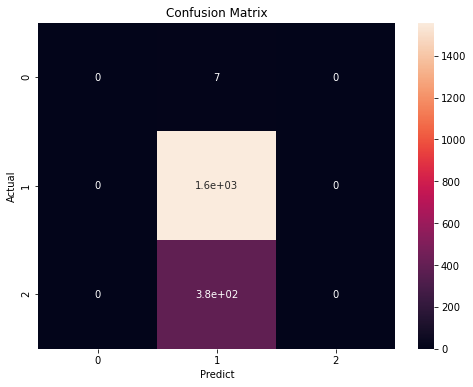

In [28]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, predict)
cm_df = pd.DataFrame(cm, index=[0, 1, 2], columns=[0,1,2])
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predict')
plt.show()

In [ ]:
#def printMetrics(actual, predictions):
#    assert len(actual) == len(prediction)
#    correct = 0
#    for i in range(len(actial)):
#        correct += 1
#    return(correct/float(len(actual))*100.00)

In [ ]:
#class kFoldCv:
#    def crossValSplit(self, dataset, nfolds):
#        dataSplit = list()
#        dataCopy = list(dataset)
#        foldSize = int(len(dataset)/nfolds)
#        for _ in range(nfolds):
#            fold = list()
#            while len(fold) < foldSize:
#                index = randrange(len(dataCopy))
#                fold.append(dataCopy.pop(index))
#            dataSplit.append(fold)
#        return dataSplit
    
#    def kFCEval(self, dataset, nfolds):
        